In [2]:
import pandas as pd
import cvxpy as cp
import numpy as np
datasets = [pd.read_csv('/Users/.../Desktop/MA706_SVM/data' + str(i) + '.csv') for i in range(1,7)]

In [ ]:
import matplotlib.pyplot as plt
for g in range(len(datasets)-1):
    data = datasets[g].values
    x = np.linspace(0, 1, 1000)
    fig, ax = plt.subplots()
    ax.scatter(x = data[:,0], y = data[:,1], c = data[:,-1])
    ax.set_title('Dataset ' + str(g+1))
    #plt.savefig(fname='Dataset ' + str(g+1))
    plt.show()

A quick note about the code: in the paper that explains this file, you will often see m x n used in the matrix notation. The data arrays below are actually the transpose of this despite being labeled m,n as the rows and columns. This is an unfortunate confusion, but not fatal to our results. 

## Primal LSVM 

In [28]:
def primal_lsvm(data):
    X = data[:,:-1]
    m,n = X.shape
    y = data[:,-1]
    # Create two scalar optimization variables
    w = cp.Variable(n)
    b = cp.Variable()

    # y_i * (w^T x + b) >= 1 is the only constraint, but for p points
    constraints = []
    for i in range(len(data)):
        constraints.append(y[i]*(X[i] @ w + b) >= 1)

    # Form objective.
    #Sum of squares of w vector--> CONVEX PROBLEM
    obj = cp.Minimize(0.5* cp.norm(w, 2)) 

    # Form and solve problem.
    prob = cp.Problem(obj, constraints)
    prob.solve()  # Returns the optimal value.
    print("status of", prob.status)
    print("optimal value of ", prob.value)
    print("optimal var of", w.value, b.value)
    

for k in range(len(datasets)):
    primal_lsvm(datasets[k].values)

status of optimal
optimal value of  10.291970388224076
optimal var of [-9.44837016 18.28734314] -4.493304194715332
status of infeasible
optimal value of  inf
optimal var of None None
status of infeasible
optimal value of  inf
optimal var of None None
status of infeasible
optimal value of  inf
optimal var of None None
status of infeasible
optimal value of  inf
optimal var of None None
status of infeasible
optimal value of  inf
optimal var of None None


status of optimal
optimal value of  10.291970388224076
optimal var of [-9.44837016 18.28734314] -4.493304194715332


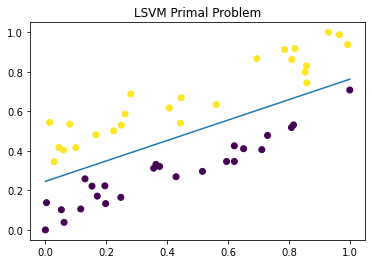

In [27]:
import matplotlib.pyplot as plt
data = datasets[0].values
X = data[:,:-1]
m,n = X.shape
y = data[:,-1]
w = cp.Variable(n)
b = cp.Variable()
constraints = []
for i in range(len(data)):
    constraints.append(y[i]*(X[i] @ w + b) >= 1)
obj = cp.Minimize(0.5* cp.norm(w, 2)) 
prob = cp.Problem(obj, constraints)
prob.solve()
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
ax.scatter(x = data[:,0], y = data[:,1], c = data[:,2])
ax.plot(x, -(w.value[0]/ w.value[1])*x - (b.value/ w.value[1]), linestyle='-')  # solid
ax.set_title('LSVM Primal Problem')
plt.show()

## Dual LSVM

In [80]:
from cvxopt import matrix as mat
from cvxopt import solvers as solve

data = datasets[0].values
X = data[:,:-1]
y = data[:,-1]
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.


P = mat(H)
q = mat(-np.ones((m, 1)))
G = mat(-np.eye(m))
h = mat(np.zeros(m))
A = mat(y.reshape(1, -1))
b = mat(np.zeros(1))

sol = solve.qp(P, q, G, h, A, b, verbose=False)
alphas = np.array(sol['x'])
w = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)
print('w = ', w)
print('b = ', b[0])

     pcost       dcost       gap    pres   dres
 0: -1.9520e+01 -5.4239e+01  3e+01  2e-15  2e+00
 1: -2.7335e+01 -3.8769e+01  1e+01  1e-15  8e-01
 2: -8.6112e+01 -1.0158e+02  2e+01  8e-14  8e-01
 3: -1.5263e+02 -1.8826e+02  4e+01  1e-14  6e-01
 4: -2.0354e+02 -2.3728e+02  3e+01  6e-14  3e-01
 5: -2.1172e+02 -2.1444e+02  3e+00  4e-14  1e-02
 6: -2.1185e+02 -2.1188e+02  3e-02  9e-14  1e-04
 7: -2.1185e+02 -2.1185e+02  3e-04  1e-13  1e-06
 8: -2.1185e+02 -2.1185e+02  3e-06  9e-14  1e-08
Optimal solution found.
w =  [[-9.44837008]
 [18.287343  ]]
b =  [-4.49330417]


## Compromised LSVM

In [84]:
data = datasets[5].values
X = data[:,:-1]
m,n = X.shape
y = data[:,-1]
# Create two scalar optimization variables
w = cp.Variable(n)
b = cp.Variable()
t = cp.Variable(m)

# y_i * (w^T x + b) >= 1 is the only constraint, but for p points
constraints = [t >= 0]
for i in range(len(data)):
    constraints.append(1- y[i]*(X[i] @ w + b) <= t[i])
# Form objective.
#Sum of squares of w vector--> CONVEX PROBLEM
obj = cp.Minimize(cp.sum(t))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", w.value, b.value)


pred = np.array([ np.dot(w.value, X[i]) + b.value for i in range(len(data))])
a = pred > 0
b = y>0
np.sum(a==b) / len(a) #accuracy of our model

status: optimal
optimal value 5.600000000551337
optimal var [  1.2   8.   -6.4 -19.2] 33.59999999425281


0.98

## Linear Soft SVM

In [102]:
data = datasets[0].values
X = data[:,:-1]
m,n = X.shape
y = data[:,-1]
# Create two scalar optimization variables
w = cp.Variable(n)
b = cp.Variable()
t = cp.Variable(m)
C = 0.95

# y_i * (w^T x + b) >= 1 is the only constraint, but for p points
constraints = [t >=0]
for i in range(len(data)):
    constraints.append(y[i]*(X[i] @ w + b) >= 1 - t[i])

# Form objective.
#Sum of squares of w vector--> CONVEX PROBLEM
obj = cp.Minimize(0.5* cp.norm(w, 2) + cp.sum(t)) 

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", w.value, b.value)

status: optimal
optimal value 7.308007031668247
optimal var [-4.25530101  9.09725646] -2.3639988520449386


## LSVM with Two Different Kernel Functions

In [228]:
from numpy import linalg as LA
data = datasets[0].values
X = data[:,:-1]
m,n = X.shape
y = data[:,-1]
y_diag = np.diag(y)
y_diag

def radial_basis_function(x1,x2,sigma):
    return np.exp(-(LA.norm(x1-x2)**2)/ (2*(sigma**2)))
def sigmoid(x1,x2,beta,theta):
    return np.tanh(beta*(np.dot(x1,x2))+theta)

K1 = np.zeros((m,m))
K2 = np.zeros((m,m))


sigma = 1
beta = 0.8
theta= 1
for i in range(m):
    for j in range(m):
        K1[i,j] = radial_basis_function(X[i],X[j],sigma)
        K2[i,j] = sigmoid(X[i],X[j],beta,theta)
        
H1 = np.matmul(y_diag, np.matmul(K1,y_diag))
H2 = np.matmul(y_diag, np.matmul(K2,y_diag))

print(H2)

[[ 0.78829576  0.77344151  0.8122197  ... -0.82469674 -0.80716803
  -0.80996089]
 [ 0.77344151  0.76790301  0.77783204 ... -0.79194369 -0.78535314
  -0.78408147]
 [ 0.8122197   0.77783204  0.8807966  ... -0.86778647 -0.82941509
  -0.84706861]
 ...
 [-0.82469674 -0.79194369 -0.86778647 ...  0.89399332  0.86486285
   0.86830392]
 [-0.80716803 -0.78535314 -0.82941509 ...  0.86486285  0.84374369
   0.84223845]
 [-0.80996089 -0.78408147 -0.84706861 ...  0.86830392  0.84223845
   0.84580467]]


In [229]:
#All that's left for you to do here is to recompute H= Diag(y)KDiag(y)
#where $K_ij = kernel function between x_i,x_j (should be symmetric)
#in fact it has to be symmetric positive semidefinite or else not QP
y_prime = y.reshape(-1,1) * 1.
X_dash = y_prime * X
H = np.dot(X_dash , X_dash.T) * 1.


P = mat(H1)
q = mat(-np.ones((m, 1)))
G = mat(-np.eye(m))
h = mat(np.zeros(m))
A = mat(y_prime.reshape(1, -1))
b = mat(np.zeros(1))

sol = solve.qp(P, q, G, h, A, b, verbose=False)
alphas = np.array(sol['x'])

#recovering w
w = ((y_prime * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y_prime[S] - np.dot(X[S], w)
print('w = ', w)
print('b = ', b[0])

     pcost       dcost       gap    pres   dres
 0: -2.0784e+01 -5.9118e+01  4e+01  2e-16  2e+00
 1: -2.9118e+01 -4.2102e+01  1e+01  2e-15  8e-01
 2: -5.5783e+01 -7.1138e+01  2e+01  1e-14  8e-01
 3: -1.1945e+02 -1.4796e+02  3e+01  1e-14  7e-01
 4: -1.7322e+02 -2.1191e+02  4e+01  2e-14  4e-01
 5: -1.9268e+02 -2.0201e+02  9e+00  3e-14  6e-02
 6: -1.9328e+02 -1.9340e+02  1e-01  9e-14  7e-04
 7: -1.9328e+02 -1.9328e+02  1e-03  9e-14  7e-06
 8: -1.9328e+02 -1.9328e+02  1e-05  6e-14  7e-08
Optimal solution found.
w =  [[-12.35303669]
 [ 17.27155498]]
b =  [-3.85290516]


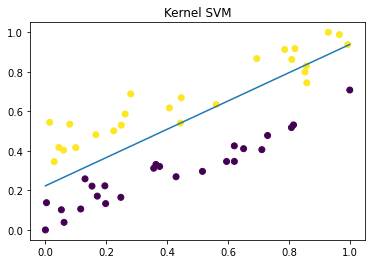

In [230]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
ax.scatter(x = data[:,0], y = data[:,1], c = data[:,2])
ax.plot(x, -(w[0]/ w[1])*x - (b[0]/ w[1]), linestyle='-')  # solid
ax.set_title('Kernel SVM')
plt.show()

## Quadratic Surface SVM

In [79]:
#uses cvxpy
data = datasets[0].values
X = data[:,:-1]
m,n = X.shape
y = data[:,-1]
# Create n x n quadratic matrix
W = cp.Variable((n,n))
b = cp.Variable(n)
c = cp.Variable()

expr = 0
for i in range(len(X)):
    expr = expr + cp.norm(W  @ X[i] + b, 2)
    
constraints = []
for i in range(len(X)):
    constraints.append(y[i]*(0.5*cp.quad_form(X[i],W) + cp.multiply(b,X[i]) + c) >= 1)

# Form objective.
# CONVEX PROBLEM
obj = cp.Minimize(expr) 
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status of", prob.status)
print("optimal value of ", prob.value)
print("optimal var of", W.value, b.value, c.value)


status of optimal
optimal value of  548.3065381771187
optimal var of [[  9.17872594  -5.16234774]
 [-44.64529281  56.55321568]] [-1.19097465e-08 -1.65097864e-09] -2.1267354092962703
